# PyTorch Image Classification CNN

In [1]:
pip install timer

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torchvision.transforms import v2
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from timeit import default_timer as timer
from torchsummary import summary

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## Getting a dataset

In [3]:
transforms = v2.Compose([
    ToTensor()
])

In [5]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download data to?
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=transforms,  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None,  # you can transform labels as well
)

train_data_len = len(train_data)
TRAIN_SPLIT = int(train_data_len * 0.9)
VAL_SPLIT = int(train_data_len * 0.1)

train_data, val_data = torch.utils.data.random_split(train_data, [TRAIN_SPLIT, VAL_SPLIT])

# Setup testing data
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms)  # get test data


Let's check out the first sample of the training data.

In [6]:
class_names = test_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Sneaker')

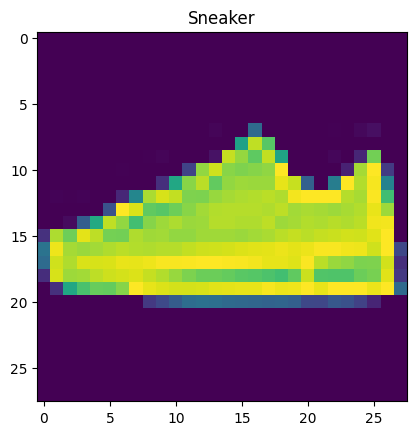

In [9]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())  # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(class_names[label])

In [ ]:
image.shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

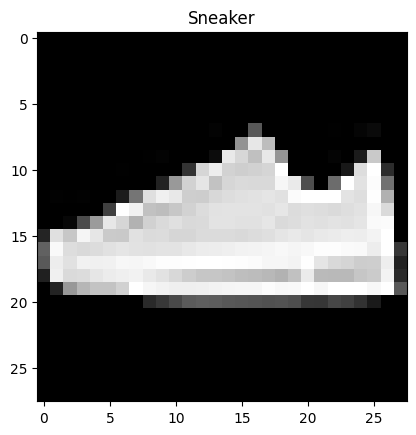

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

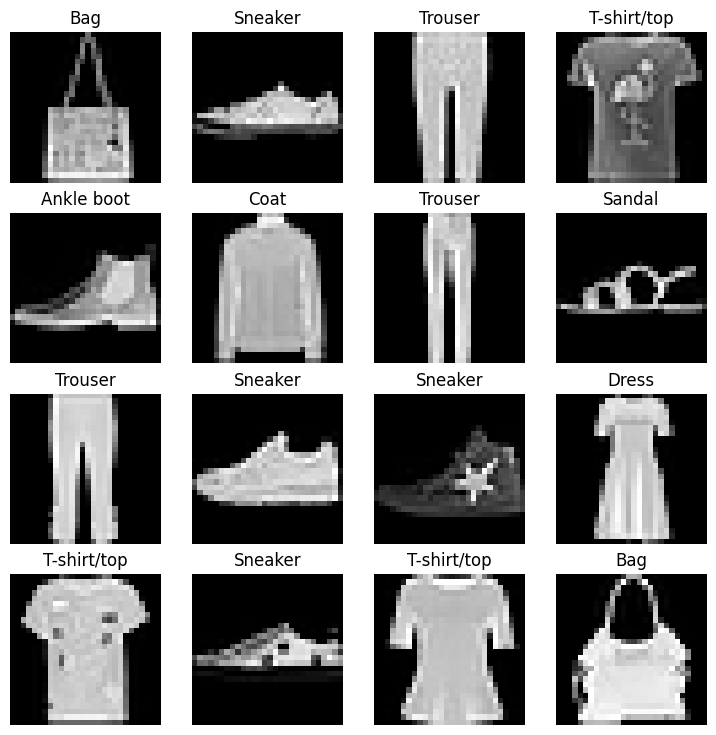

In [11]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Prepare DataLoader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dacde5e7e10>, <torch.utils.data.dataloader.DataLoader object at 0x7dacde72df90>)
Length of train dataloader: 1688 batches of 32
Length of test dataloader: 313 batches of 32


In [13]:
len(train_data), len(train_dataloader)

(54000, 1688)

In [ ]:
1688*32

54016

In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [15]:
!nvidia-smi

Wed Jun 25 10:10:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


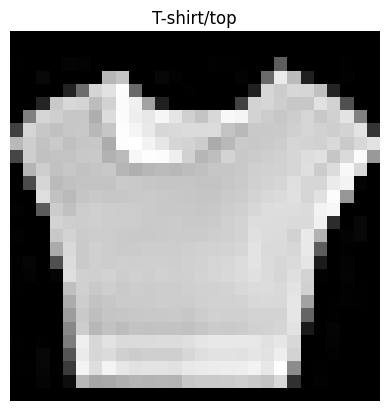

In [16]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Training and test loops

In [19]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results


In [20]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

## Deep Learning is about shapes keep track of your shapes !!!

![image-2.png](attachment:image-2.png)

In [23]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, output_shape = 10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # x.shape: [n_samples = batch_size, n_channels = 1, H = 28, W = 28]
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            # ((28 - 3 + 2) / 2)  + 1 = 14
            # output size: [batch_size, 32, 14, 14]
            # x.shape: [n_samples = batch_size, n_channels = 32, H = 14, W = 14]
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            # output size: ((14 - 3 + 2) / 2)  + 1 = 7
            # x.shape: [n_samples = batch_size, n_channels = 64, H = 7, W = 7]
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1),
            # output size: 5
            # x.shape: [n_samples = batch_size, n_channels = 128, H = 5, W = 5]
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # output size: 2
            # x.shape: [n_samples = batch_size, n_channels = 128, H = 2, W = 2]
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Flatten(),# [128 x 8 x 8] -> [128*8*8]
            # x.shape [n_samples = batch_size, 128*2*2]
            nn.Dropout(0.3),
            nn.Linear(in_features=128 * 2 * 2, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [24]:
torch.manual_seed(42)
model_0 = CNN().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [25]:
summary(model_0.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 5, 5]          73,856
         MaxPool2d-6            [-1, 128, 2, 2]               0
              ReLU-7            [-1, 128, 2, 2]               0
           Flatten-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 512]         262,656
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 360,458
Trainable params:

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.005)

In [27]:
results = train(
    model=model_0,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=3,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5843 | train_acc: 78.1194 | test_loss: 0.4328 | test_acc: 83.5605 | time: 11.2555
Epoch: 2 | train_loss: 0.4719 | train_acc: 82.3367 | test_loss: 0.4098 | test_acc: 84.6077 | time: 11.5655
Epoch: 3 | train_loss: 0.4461 | train_acc: 83.3605 | test_loss: 0.3797 | test_acc: 85.3225 | time: 11.2758


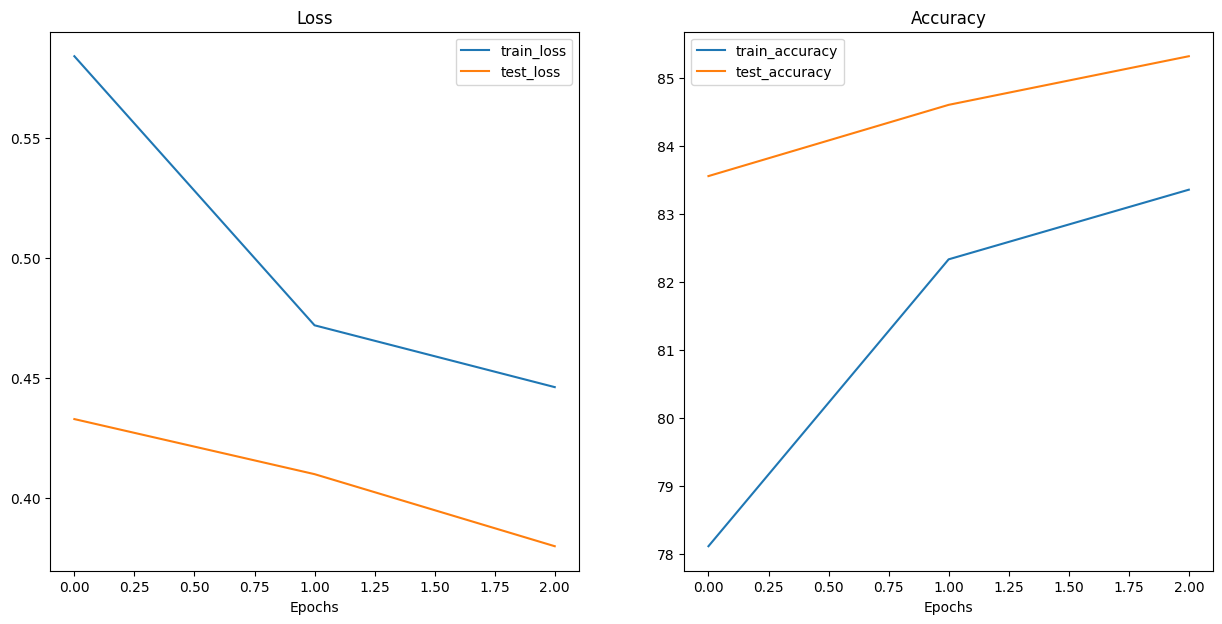

In [28]:
plot_loss_curves(results)

In [29]:
test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(0.42173734973794735, 83.72603833865814)

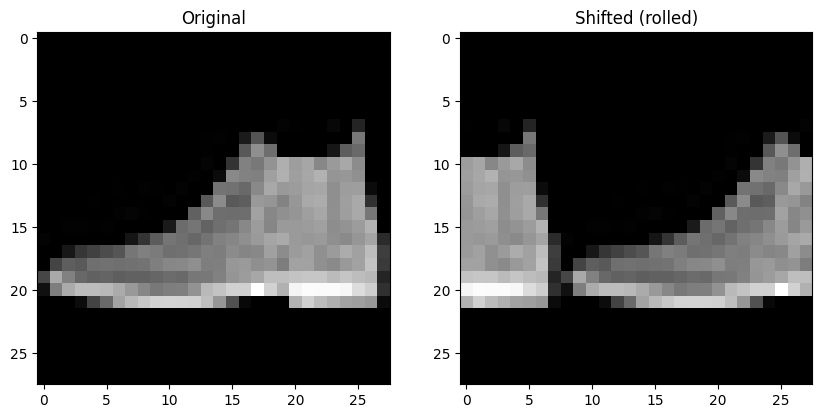

In [30]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_dataloader.dataset.data[0,:]
tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)

# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [31]:
for i in range(test_dataloader.dataset.data.shape[0]):

    # get the image
    img = test_dataloader.dataset.data[i,:]

    # reshape and roll by max. 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll( img.reshape(28,28) ,randroll,dims=1 )

    # re-vectorize and put back into the matrix
    test_dataloader.dataset.data[i,:] = img

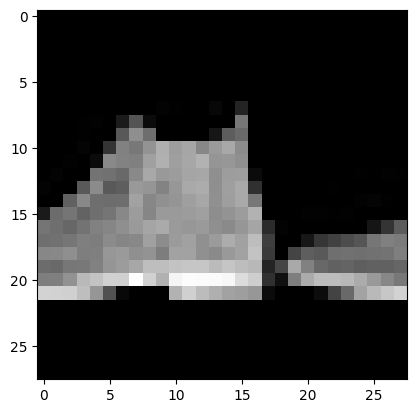

In [32]:
for i in range(test_dataloader.dataset.data.shape[0]):

    # get the image
    img = test_dataloader.dataset.data[i,:]
    plt.imshow(img.squeeze(), cmap="gray")

    plt.show()
    break

In [33]:
test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(3.6777192144729076, 34.9341054313099)